In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from mmctools.plotting import plot_timeheight, plot_timehistory_at_height, plot_profile, plot_spectrum

In [4]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16

In [5]:
# TODO:
# - Add advanced example section to show more options

# Demonstrate standard plotting tools

## Load data

Load a processed TTU dataset for demonstration purposes. The dataset can be obtained by running the notebook "process_TTU_tower.ipynb" which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment) (currently only in the dev branch)

In [6]:
datadir = './'
TTUdata = 'TTU_tilt_corrected_20131108-09.csv'

In [7]:
df = pd.read_csv(os.path.join(datadir,TTUdata),parse_dates=True,index_col='datetime')
df.head()

,height,u,v,w,t,ts,p
datetime,,,,,,,
2013-11-08,0.9,-0.138929,2.637817,0.074016,284.794,289.410000,908.547754
2013-11-08,2.4,-0.601111,2.783204,0.487330,284.932,290.979994,908.723508
2013-11-08,4.0,0.416792,4.043940,0.295800,285.166,287.520000,908.215548
2013-11-08,10.1,-0.276479,5.227110,-0.418065,285.298,287.250000,907.611414
2013-11-08,16.8,0.034364,5.908367,-0.173836,285.414,287.610000,907.307654


Do some additional data processing

In [8]:
# Calculate wind speed and direction
df['wspd'] = np.sqrt(df['u']**2 + df['v']**2)
df['wdir'] = 180. + np.arctan2(df['u'],df['v'])*180./np.pi

In [9]:
# Calculate 10min averages
df10 = df.pivot(columns='height',values=['wspd','wdir']).resample('10min').mean().stack()
df10.reset_index(inplace=True)
df10.set_index(['datetime'],inplace=True)

## Simple examples

In [10]:
TTU_heights = df10.height.unique()

/home/dallaert/.conda-envs/py3env/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


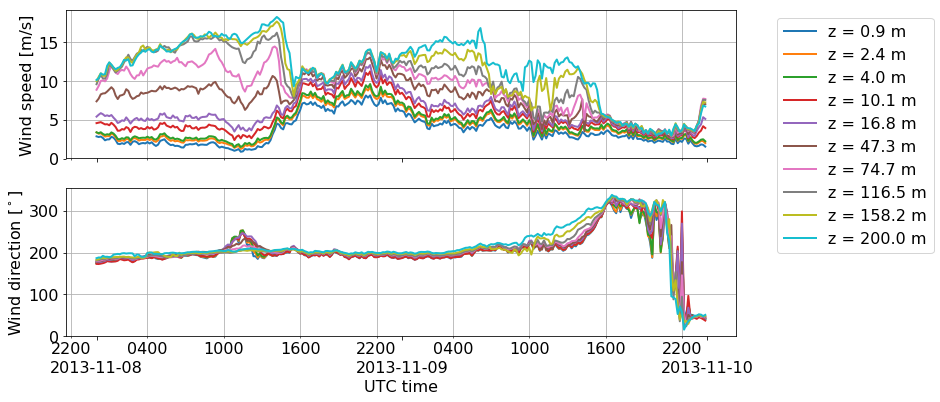

In [11]:
fig,ax = plot_timehistory_at_height(df10,
                                    fields = ['wspd','wdir'],
                                    heights = TTU_heights,
                                   )

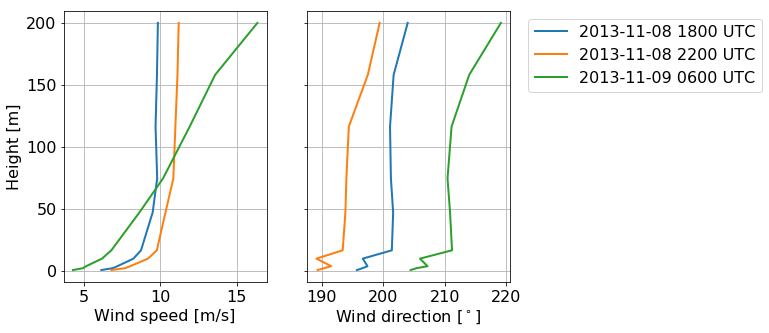

In [12]:
fig,ax = plot_profile(df10,
                      fields = ['wspd','wdir'],
                      times = ['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 6:00:00'],
                     )

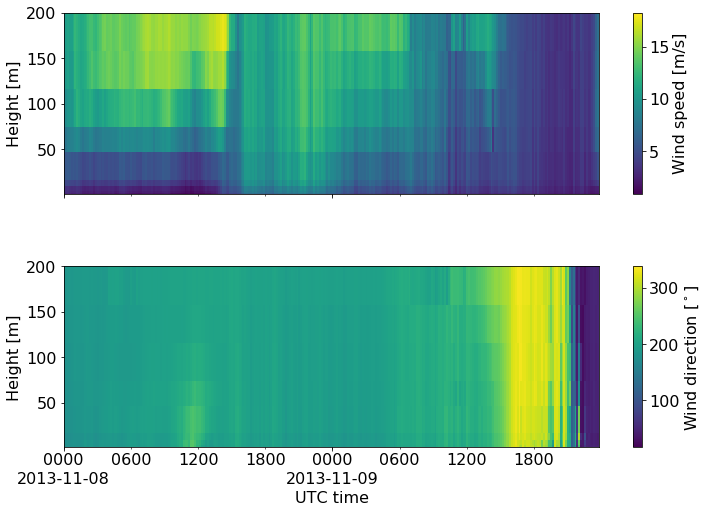

In [13]:
fig,axs,cbars = plot_timeheight(df10,
                                fields = ['wspd','wdir'],
                               )

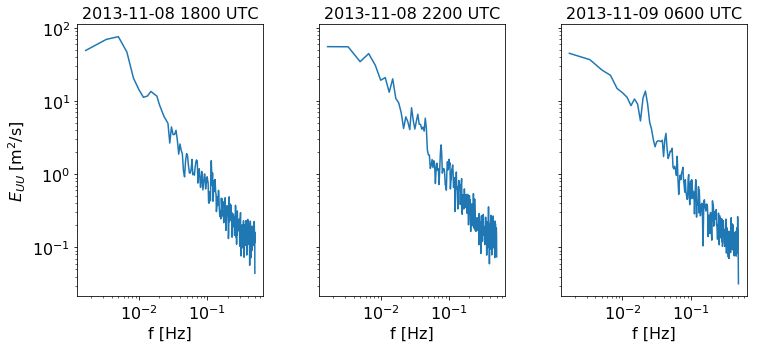

In [14]:
fig,ax = plot_spectrum(df,
                       height = 80,
                       fields = 'wspd',
                       times = ['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 6:00:00'],
                      )